In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import featuretools as ft
import sklearn
from sklearn.model_selection import train_test_split
import shap
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut

In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")

# Data

In [3]:
#activities + heart
activities = pd.read_csv('activities_final.txt', sep='\t')
activities = activities.drop(['activity_Run', 'activity_Walk', 'race', 'gender', 'activeScore', 'caloriesBMR'], axis = 1)

In [4]:
#remove partial days
valid_days = pd.read_csv('included_days.txt', sep='\t') 
activity = pd.merge(activities, valid_days, left_on=['User', 'Date'], right_on=['User', 'Day'])
activity.drop('Day', axis=1, inplace=True)

In [5]:
sleep = pd.read_csv('sleep_final.txt', sep='\t')

In [6]:
def classify_sleep(row):
    main_sleep_conditions = all(pd.isna(row[key]) for key in ['asleep_count', 'asleep_minutes', 
                                                             'awake_count', 'awake_minutes',
                                                             'restless_minutes', 'restless_count'])
    nap_conditions = all(pd.isna(row[key]) for key in ['deep_count', 'deep_minutes', 'deep_thirtyDayAvgMinutes', 
                                                      'light_count', 'light_minutes', 'light_thirtyDayAvgMinutes',
                                                      'rem_count', 'rem_minutes', 'rem_thirtyDayAvgMinutes',
                                                      'wake_count', 'wake_minutes', 'wake_thirtyDayAvgMinutes'])
    if nap_conditions:
        return "Nap"
    elif main_sleep_conditions:
        return "Main Sleep"
    else:
        return "Inconclusive"

sleep['classification'] = sleep.apply(classify_sleep, axis=1)

In [7]:
#mainsleep
mainsleep = sleep[sleep['classification']=='Main Sleep']
mainsleep = mainsleep.drop(['startTime', 'endTime', 'gender', 'race',
                'duration', 'isMainSleep', 'classification'], axis=1) 
mainsleep = mainsleep.dropna(axis = 1) 

In [8]:
common_features = ['label', 'User', 'age', 'Date']
df = pd.merge(activity, mainsleep, on=common_features, how='inner')
df = df.drop_duplicates(subset=['User', 'Date'], keep='first').reset_index(drop=True)

In [9]:
unique_df = df[['User', 'label']].drop_duplicates()

# Basic functions

In [10]:
# function engineering
def feature_engineer(data):
    es = ft.EntitySet(id = 'days_n_activities_heartrate_mainsleep')
    es.add_dataframe(dataframe_name = 'days_n', dataframe = data, make_index = True, index = 'days_n_index')
    es.normalize_dataframe(base_dataframe_name='days_n', new_dataframe_name='person', index = 'User', 
            additional_columns = ['age'])
    days_n_feature_matrix, feature_names = ft.dfs(entityset=es, target_dataframe_name = 'person', 
                                                  max_depth = 2, verbose = 1)
    return days_n_feature_matrix

In [11]:
# preliminary predictive model + feature selection
def preliminary_model(X, y):
    alpha = 0.02
    kf = KFold(n_splits=5, shuffle=True, random_state=42) 

    ix_training, ix_test = [], []

    for fold in kf.split(X):
        ix_training.append(fold[0]), ix_test.append(fold[1])

    models = []
    auc_scores = []
    feature_occurrences = {} 

    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
        X_train, y_train = X.iloc[train_outer_ix], y.iloc[train_outer_ix]
        X_test, y_test = X.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
        #model
        model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=8, l2_leaf_reg=3, random_seed=8, 
                               loss_function='Logloss')
        model.fit(X_train, y_train, cat_features = [], verbose = 0)
    
        #SHAP in training
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train) 
        shap_importance = np.mean(np.abs(np.array(shap_values)), axis = 0)
        important_features = np.array(X_train.columns)[shap_importance > alpha]

        #count
        for feature in important_features:
            if feature in feature_occurrences:
                feature_occurrences[feature] += 1
            else:
                feature_occurrences[feature] = 1
                
    models.append(model)

    final_selected_features = [feature for feature, count in feature_occurrences.items() if count >= 2]
    return final_selected_features

In [12]:
# final model - repeated kfold cv
def final_model1(X_days_n_filtered, y):
    scaler_z = StandardScaler()
    X_days_n_filtered = pd.DataFrame(scaler_z.fit_transform(X_days_n_filtered), columns=X_days_n_filtered.columns)
    
    rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

    models = []
    r_auc_scores = []
    all_shap_values = []
    all_X_tests = []
    
    for i, (train_outer_ix, test_outer_ix) in enumerate(rkf.split(X_days_n_filtered)): 
        X_train, y_train = X_days_n_filtered.iloc[train_outer_ix], y.iloc[train_outer_ix]
        X_test, y_test = X_days_n_filtered.iloc[test_outer_ix], y.iloc[test_outer_ix]
    
        model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=8, l2_leaf_reg=3, random_seed=7, 
                                   loss_function='Logloss')
        model.fit(X_train, y_train, cat_features=[], verbose=0)
    
        # test
        yhat_probs = model.predict_proba(X_test)[:, 1]
    
        # auc
        try:
            auc = roc_auc_score(y_test, yhat_probs)
            r_auc_scores.append(auc)
        except ValueError:
            print("Skipping AUC calculation for this fold due to single class in y_true.")
            r_auc_scores.append(float('nan')) 
    
        models.append(model)
        
    return r_auc_scores

In [13]:
# final model - loocv
def final_model2(X_days_n_filtered, y):
    scaler_z = StandardScaler()
    X_days_n_filtered = pd.DataFrame(scaler_z.fit_transform(X_days_n_filtered), columns=X_days_n_filtered.columns)
    
    cv = LeaveOneOut()

    models = []
    all_y_test = []
    all_yhat_probs = []

    for train_ix, test_ix in cv.split(X_days_n_filtered):
        X_train, y_train = X_days_n_filtered.iloc[train_ix], y.iloc[train_ix]
        X_test, y_test = X_days_n_filtered.iloc[test_ix], y.iloc[test_ix]
    
        userids_test = X_days_n_filtered.iloc[test_ix].index.values

        model = CatBoostClassifier(iterations=200, learning_rate=0.01, depth=8, l2_leaf_reg=3, random_seed=7, 
                               loss_function='Logloss')
        model.fit(X_train, y_train, cat_features = [], verbose = 0)

        yhat_probs = model.predict_proba(X_test)[:, 1]
    
        all_y_test.extend(y_test)
        all_yhat_probs.extend(yhat_probs)
        
        models.append(model)
        
    return all_y_test, all_yhat_probs

# Merge

In [14]:
unique_df.set_index('User', inplace=True)
y = unique_df['label']

In [15]:
auc_days_n_kfold = []
auc_days_n_loocv = []

for i in range(1, 31):
    def get_records(data):
        if len(data) > i:
            return data.head(i)
        return data
    
    X_days_n = df.groupby('User').apply(get_records).reset_index(drop=True)

    X_days_n = X_days_n.drop(['label', 'Date'], axis = 1)
    
    days_n_feature_matrix = feature_engineer(X_days_n) #feature engineer
    important_features = preliminary_model(days_n_feature_matrix, y) #preliminary predictive model
    X_days_n_filtered =  days_n_feature_matrix[important_features]
    aucs = final_model1(X_days_n_filtered, y) #final model repeated k fold
    all_y_test, all_yhat_probs = final_model2(X_days_n_filtered, y) #final model loocv
    
    auc_days_n_kfold.append(np.nanmean(aucs))
    auc_days_n_loocv.append(roc_auc_score(all_y_test, all_yhat_probs))

Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Built 332 features
Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████


The provided callable <function mean at 0x103faa5c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function amax at 0x103fa98a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
The provided callable <function sum at 0x103fa8f40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function std at 0x103faa7a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
The provided callable <function amin at 0x103fa9a80> is currently using SeriesGroupBy.min. In a future versi

Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.
Skipping AUC calculation for this fold due to single class in y_true.


In [16]:
auc_days_n_kfold

[0.8055555555555556,
 0.884920634920635,
 0.742063492063492,
 0.9761904761904762,
 0.9722222222222223,
 0.9047619047619048,
 0.9682539682539681,
 0.9682539682539681,
 0.9087301587301588,
 0.9404761904761905,
 0.8928571428571429,
 0.9404761904761905,
 0.9444444444444445,
 0.984126984126984,
 0.984126984126984,
 0.9682539682539681,
 0.9682539682539681,
 0.9206349206349206,
 0.9087301587301587,
 0.9523809523809523,
 1.0,
 0.984126984126984,
 1.0,
 0.9603174603174602,
 0.984126984126984,
 0.984126984126984,
 1.0,
 0.984126984126984,
 0.9722222222222221,
 0.9722222222222221]

In [17]:
auc_days_n_loocv

[0.75,
 0.875,
 0.6354166666666666,
 0.9895833333333334,
 0.90625,
 0.8437500000000001,
 0.9166666666666667,
 0.9479166666666666,
 0.8645833333333333,
 0.9375,
 0.8958333333333334,
 0.9270833333333333,
 0.9479166666666666,
 0.9375,
 0.9479166666666667,
 0.90625,
 0.90625,
 0.90625,
 0.8958333333333334,
 0.9791666666666666,
 1.0,
 0.9791666666666666,
 1.0,
 0.9583333333333333,
 0.9791666666666666,
 0.9895833333333334,
 0.9895833333333334,
 0.9895833333333334,
 0.9479166666666666,
 0.9479166666666667]

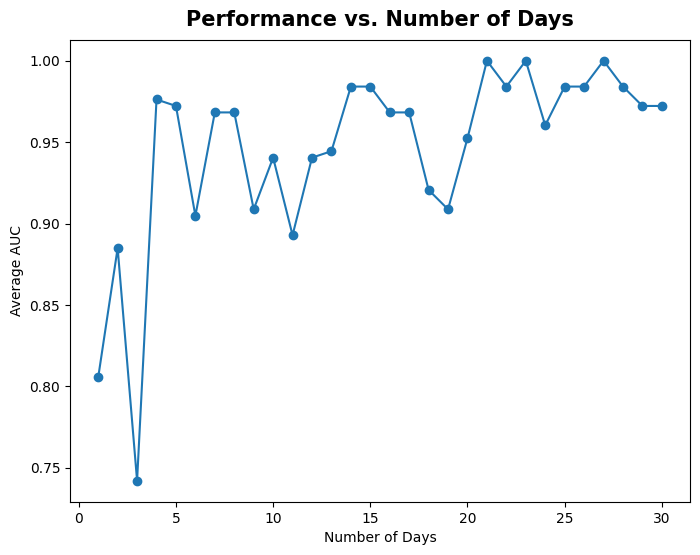

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 31), auc_days_n_kfold, marker='o')
plt.xlabel('Number of Days', fontsize=10)
plt.ylabel('Average AUC', fontsize=10)
plt.title('Performance vs. Number of Days', fontweight='bold', fontsize=15, pad=10)
plt.savefig('Min days K fold.pdf', dpi=1000, bbox_inches='tight')
plt.show()

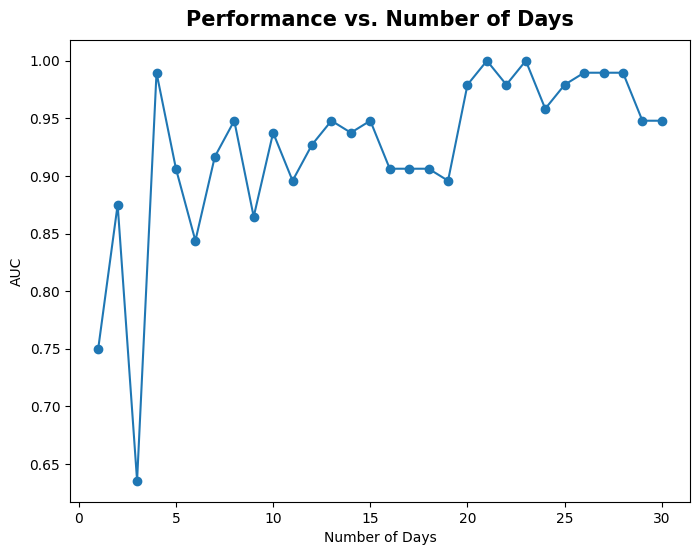

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 31), auc_days_n_loocv, marker='o')
plt.xlabel('Number of Days', fontsize=10)
plt.ylabel('AUC', fontsize=10)
plt.title('Performance vs. Number of Days', fontweight='bold', fontsize=15, pad=10)
plt.savefig('Min days loocv.pdf', dpi=1000, bbox_inches='tight')
plt.show()